In [167]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Thu Oct 24

@author: yaning
"""

import Receptors as Receptors
import importlib
import numpy as np
import matplotlib.pyplot as plt

importlib.reload(Receptors)

# import debugpy
# debugpy.listen(("0.0.0.0", 8888))  # Replace 5678 with your desired port number
# print("Debugger is ready. Attach in VS Code.")
# debugpy.wait_for_client()
# # debugpy.breakpoint()  # Optionally set a breakpoint here
# print("Debugger is attached, ready to debug.")

<module 'Receptors' from '/home/yaning/Documents/Spiking_NN/Receptors.py'>

In [168]:
class Neuron:
    _Cm = 1

    def __init__(self, deltaTms, I, Vm):
        self.deltaTms = deltaTms
        self.I = I
        self.Vm = Vm
        self.incoming_synapses = []
        self.outgoing_synapses = []
    
        self._sodium_channel = Receptors.Voltage_Sodium(self.Vm)
        self._potassium_channel = Receptors.Voltage_Potassium(self.Vm)
        self._leaky_channel = Receptors.Voltage_Leak(self.Vm)

    # when the pre synapses fire, it activates this function
    def inject_current(self, sum_currents):
        self.I += sum_currents
    
    # voltage and ion channel currents update has to be here because it sums from all dendrites
    def update(self):
        # ion channel currents
        self._sodium_channel.update_gP(self.deltaTms)
        self._potassium_channel.update_gP(self.deltaTms)
        Ina = self._sodium_channel.current()
        Ik = self._potassium_channel.current()
        Ileak = self._leaky_channel.current()

        # add the ion channel currents
        self.I = self.I + Ina + Ik + Ileak
        self.Vm += - self.deltaTms * self.I / self._Cm

        # update the ion channel voltage
        self._sodium_channel.Vm = self.Vm
        self._potassium_channel.Vm = self.Vm
        self._leaky_channel.Vm = self.Vm
    
    # when this neuron fires, send signal to the connected post synapses
    def sending_signal(self):
        for synapse in self.outgoing_synapses:
            synapse.state = 1


    # def add_incoming_synapses(self, ):
    #     self.incoming_synapses.append()

In [169]:
# ligand gated receptors belong to the synapse
class Synapse:
    def __init__(self, deltaTms, state, send_neuron, receive_neuron, *args):
        # either it is being simulated 1 or not 0
        # need the state to update gP differently
        self.deltaTms = deltaTms
        self.state = state

        # do we need send neurons?
        self.send_neuron = send_neuron
        self.receive_neuron = receive_neuron

        # the type of connection
        self.receptors = []
        if args:
            self.receptors.extend(args)
    
    # update the gP
    def update(self):
        sum_currents = 0
        for receptor in self.receptors:
            receptor.update_gP(self.state, self.deltaTms)
            sum_currents += receptor.current()
            # print(sum_currents)
        
        self.receive_neuron.inject_current(sum_currents)


In [170]:
class Control:
    def __init__(self, deltaTms, Vm):
        self.all_synapses = []
        self.deltaTms = deltaTms
        # this voltage is the post synpase neuron voltage
        self.Vm = Vm

    # also let the neurons know their connections and keep record of all synapses so they can be updated easily
    def create_synapse(self, send_neuron, receive_neuron, type):
        
        if type == "AMPA":
            ampa_receptor = Receptors.LigandGatedChannelFactory.create_AMPA(self.Vm)
            synapse = Synapse(self.deltaTms, 0, send_neuron, receive_neuron, ampa_receptor)
            
        elif type == "AMPA+NMDA":
            ampa_receptor = Receptors.LigandGatedChannelFactory.create_AMPA(self.Vm)
            nmda_receptor = Receptors.LigandGatedChannelFactory.create_NMDA(self.Vm)
            synapse = Synapse(self.deltaTms, 0, send_neuron, receive_neuron, ampa_receptor, nmda_receptor)
        
        elif type == "GABA":
            gaba_receptor = Receptors.LigandGatedChannelFactory.create_GABA(self.Vm)
            synapse = Synapse(self.deltaTms, 0, send_neuron, receive_neuron, gaba_receptor)

        send_neuron.outgoing_synapses.append(synapse)
        receive_neuron.incoming_synapses.append(synapse)

        self.all_synapses.append(synapse)
            
            

In [171]:
neuron1.outgoing_synapses[0]

In [172]:
pointCount = 5000
deltaTms = 0.05
times = np.arange(pointCount) * deltaTms
initial_Vm = 1.3458754117369027

# Neuron: deltaTms, I, Vm
neuron1 = Neuron(deltaTms, 0, initial_Vm)
neuron2 = Neuron(deltaTms, 0, initial_Vm)

# create synapse/connection
control = Control(deltaTms, initial_Vm)
control.create_synapse(neuron1, neuron2, "AMPA")

Vm_neuron1 = []
Vm_neuron2 = []
I_neuron1 = []
I_neuron2 = []

ampa_currents = []

synpase_state = []
monitor = []

for t in range(pointCount):
    neuron1.update()
    neuron2.update()
    if t >= 2000 and t <= 3000:
        neuron1.sending_signal()
    # this loop is useless for now because there is only one synapse
    for synapse in control.all_synapses:
        synapse.update()
        monitor.append(synapse.receptors[0].e)
        ampa_currents.append(synapse.receptors[0].gP)
        # record neuron Vm and I
        Vm_neuron1.append(neuron1.Vm)
        Vm_neuron2.append(neuron2.Vm)
        I_neuron1.append(neuron1.I)
        I_neuron2.append(neuron2.I)

        synpase_state.append(synapse.state)


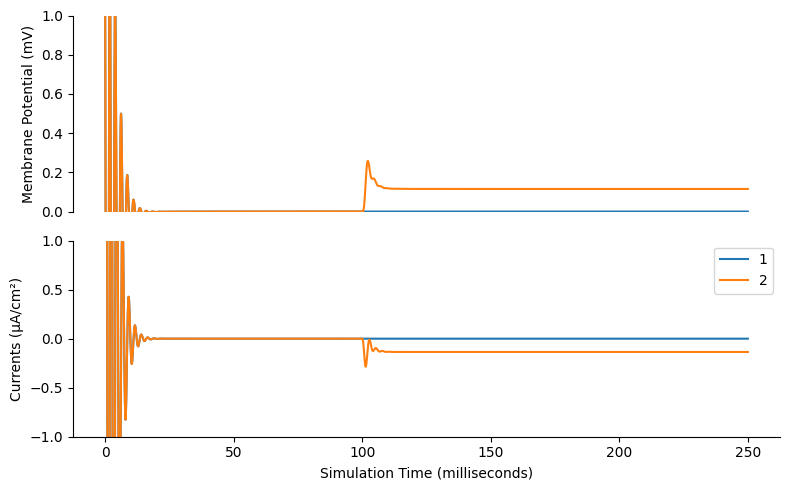

In [173]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(8, 5),
                                gridspec_kw={'height_ratios': [1, 1]})

ax1.plot(times, Vm_neuron1, label = '1')
ax1.plot(times, Vm_neuron2, label = '2')
ax1.set_ylabel("Membrane Potential (mV)")
# ax1.set_title("Hodgkin-Huxley Spiking Neuron Model", fontSize=16)
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.spines['bottom'].set_visible(False)
ax1.tick_params(bottom=False)

ax1.set_ylim(0, 1)

ax2.plot(times, I_neuron1, label = '1')
ax2.plot(times, I_neuron2, label = '2')
ax2.set_ylabel("Currents (µA/cm²)")
ax2.set_xlabel("Simulation Time (milliseconds)")
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)

ax2.set_ylim(-1,1)

plt.margins(0, 0.1)
plt.tight_layout()
plt.legend()
plt.show()

# sharp wave ripples

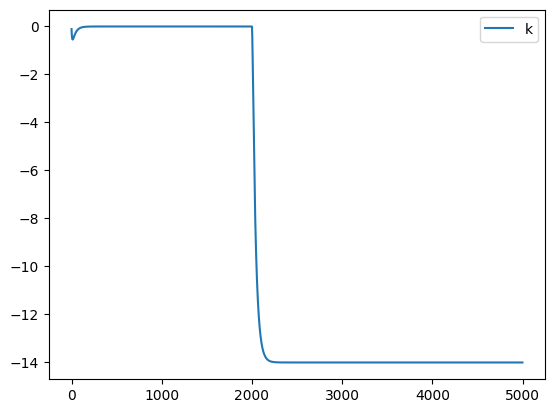

In [174]:
# plt.plot(times, leak_currents, label="leaky")
plt.plot(times/deltaTms, ampa_currents, label="k")


# plt.xlim(1998, 3000)
plt.legend()